In [1]:
import requests
import json
import re
import os
import pandas as pd 
import numpy as np
import random
import pickle
from recipe_loading import *
from qty_mapping import *
from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import *
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib
import method_mapping

The steps followed here are:

1) Load 1m recipe
2) Find top ingredient matches
3) Standardise the units
4) Load density info
5) Calculate the required amount of each ingredient
6) Indentify gadgets and methods
7) Find top gadget matches

In [43]:
from pathlib import Path
PATH = Path("")
data_path = PATH.home()/'data/Target/data/'
model_path = PATH.home()/'data/Target/models/group10'
model_path_g4 = PATH.home()/'data/Target/models/group4'
recipe_path = data_path/"layer1.json"
recipe_image_path = data_path/"layer2.json"
op_file_path = data_path/"ing_density.csv"
model_path_ner = PATH.home()/'data/Target/models/group4'

# Load recipes
with open(recipe_path) as json_data:
    recipe = json.load(json_data)

In [3]:
# Load recipe images
with open(recipe_image_path) as json_data:
    recipe_images = json.load(json_data)

In [4]:
# Get grocery product hierarchy information
group10 = pd.read_csv(data_path/'group10_header.csv',
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(data_path/'products.csv')

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

# Fill NAs
group10 = fillNa(group10)

In [34]:
# Set input file directory

# Get grocery product hierarchy information
group4 = pd.read_csv(os.path.join(data_path, 
                                   'group4_header.csv'),
                      sep=',', 
                      low_memory=False)

products_g4 = pd.read_csv(os.path.join(data_path,
                                    'products_group4.csv'))

# Merge scraped information into the hierarchy table
group4 = pd.merge(group4, products_g4, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group4 = preprocess_df(group4)

# Method gadget mapping
method_tool_mapping = method_mapping.dictionary_to_map()

In [6]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
    return stored_data
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

In [7]:
k=3

# Bi Encoder
multi_lm_embedder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
# Cross encoder 
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-4-v2', max_length=512)

In [8]:
# Classification models
pm = Mapper(group10)
clf_name_class_name = model_path/'nli-classification-class_name'
clf_name_item_type_name = model_path/'nli-classification-item_type_name'
clf_name_subclass_name = model_path/'nli-classification-subclass_name'
base_clf_class_name = CrossEncoder(clf_name_class_name)
base_clf_item_type_name = CrossEncoder(clf_name_item_type_name)
base_clf_subclass_name = CrossEncoder(clf_name_subclass_name)
clf_class_name = Classifier(base_clf_class_name, pm, 'class_name', threshold=0.98)
clf_item_type_name = Classifier(base_clf_item_type_name, pm, 'item_type_name', threshold=0.99)
clf_subclass_name = Classifier(base_clf_subclass_name, pm, 'subclass_name', threshold=0.99)

In [9]:
multi_lm_embeddings = get_embeddings(data_path/'hier_embeddings.pkl')

In [10]:
filtered_products = list(group10[~pd.isnull(group10['image'])]['tcin'].values)

# Bi encoder without classifier
multi_lm = TransformerRanker(model=multi_lm_embedder, max_rank=k, 
                            filtered_products=filtered_products)
multi_lm.load_embeddings(multi_lm_embeddings)

# Bi encoder with classifier
multi_lm_clf = TransformerRanker(model=multi_lm_embedder,
                                max_rank=k, clf=[clf_class_name, 
                                                clf_item_type_name,
                                                clf_subclass_name],
                                filtered_products=filtered_products)
multi_lm_clf.load_embeddings(multi_lm_embeddings)

# Cross encoder with classifier
cr_multi_lm_clf = CrossEncoderRanker(bi_model=multi_lm_clf, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map(data_path/'hier_embeddings.pkl'),
                        cross_rank=k,
                        bi_rank=30,
                        mapper=pm,
                        weights=True)  

# Cross encoder without classifier
cr_multi_lm = CrossEncoderRanker(bi_model=multi_lm, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map(data_path/'hier_embeddings.pkl'),
                        cross_rank=k,
                        bi_rank=30,
                        mapper=pm,
                        weights=True)  

In [11]:
# Load BM25 (For ingredients)
bm25 = joblib.load(model_path/'bm25_no_description')

In [12]:
rc = RankerCombination([bm25, multi_lm_clf], [0.4, 0.6], max_rank=10)
l2_ranker = RankerPipeline([rc, cr_multi_lm], [10, k])

In [13]:
# Get list of preprocessed product titles
product_titles = group10['title'].str.lower().values
pm = Mapper(group10)
dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [14]:
# Get random recipe from the 1M recipe corpus
i = random.randint(0, 1000000)
i=372295
print(i)
id, dict_ingredients= recipe_load_index(i, recipe)
df_combined_ing = pd.DataFrame.from_dict(dict_ingredients)
df_combined_ing['quantity'] = df_combined_ing['quantity'].apply(convert_fraction)

qty = Qty_normal_map(op_file_path= op_file_path, data=group10)

#normalise units
combined_ingredient_df=qty.normalize_units(df_combined_ing)

# required for multiple recipes - combining qty
combined_ingredient_df = qty.combine_qty(df_combined_ing)

#using density info calculating required ounces for each ingredient
final_df = qty.req_oz_recipe(combined_ingredient_df)


372295
Recipe: Sables (pronounced saab lay)


/Users/chahaksethi/Desktop/Target/target/target_recipe_project/code/notebook/qty_mapping.py:80: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  combined_ingredient_df['standard_vol'],combined_ingredient_df['standard_weight_gm'],\


In [15]:
combined_ingredient_df

,ingredient,normalized_unit,quantity,Volume_in_ml,tuple,standard_vol,standard_weight_gm,standard_unit
0,butter,grams,125.0,125.0,"(1.0, 16.0, tablespoon)",1.0,16.0,tablespoon
1,egg,count,1.0,0.0,"(1.0, 34.0, white)",1.0,34.0,white
2,flour,grams,250.0,250.0,"(1.0, 128.0, cup)",1.0,128.0,cup
3,salt,,0.0,0.0,"(1.0, 100.0, cup)",1.0,100.0,cup


In [17]:
import matplotlib.pyplot as plt
urls = []
for recipe_image in recipe_images:
    if recipe_image['id'] == id:
        for image in recipe_image['images']:
            urls.append(image['url'])
images = pm.get_images_urls(urls)

plt.figure(figsize=(20,10))
columns = 3
for i in range(len(images)):
    ax = plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
    plt.axis('off')
    # plt.title(titles[i])
    plt.imshow(images[i])

<Figure size 1440x720 with 0 Axes>

In [18]:
# Preprocess recipe ingredients
final_df['ingredient'] = preprocess(final_df['ingredient'])
recipe_ingredients = list(final_df['ingredient'].values)

# Ranked list of product tcin matches for each ingredient - Returns a list of lists 
ranked_match = l2_ranker.rank_products_recipe(recipe_ingredients)

#matching target database with recipe 
join_df = qty.match_ranked_ingredients(k, ranked_match , final_df, recipe_ingredients)

#calculating recommended quantity
rec_df = qty.recommended_quantity(join_df)
df = rec_df.sort_values(by=['ingredient', 'recommended_qty', 'price']).copy()
display_df = df[['tcin', 'ingredient', 'recommended_qty', 'price']].copy()

/Users/chahaksethi/Desktop/Target/target/target_recipe_project/code/notebook/ranker.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = torch.nn.functional.softmax(torch.tensor(scores)).numpy()


Filtered egg for class_name: EGGS
Filtered salt for class_name: SPICES


butter
[80796339 80796340 54534326]


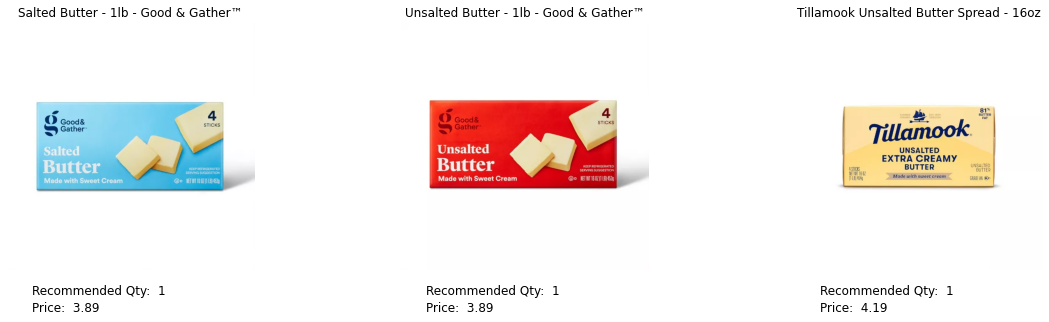

egg
[81488495 51744135 21567033]


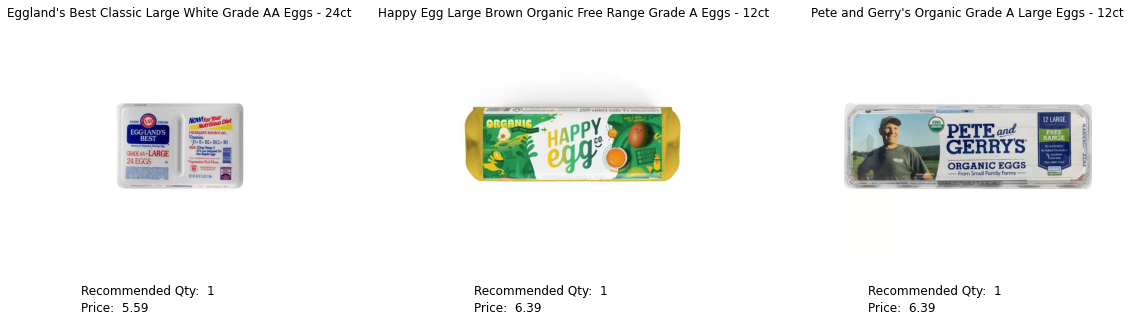

flour
[13474783 13016243 14777928]


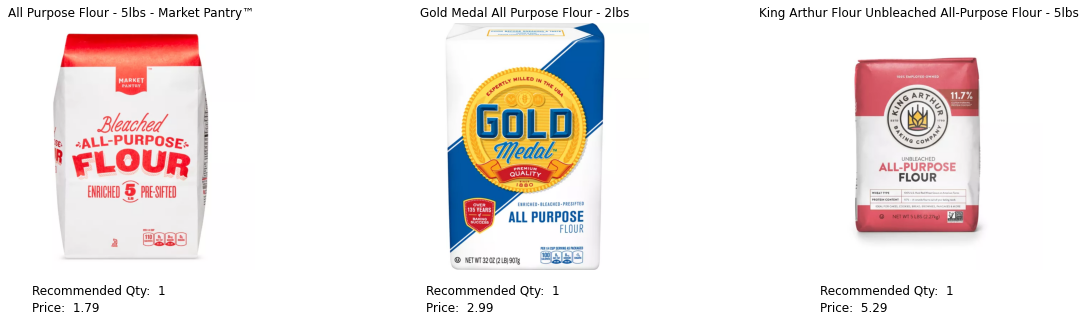

salt
[78140513 13171237 54635267]


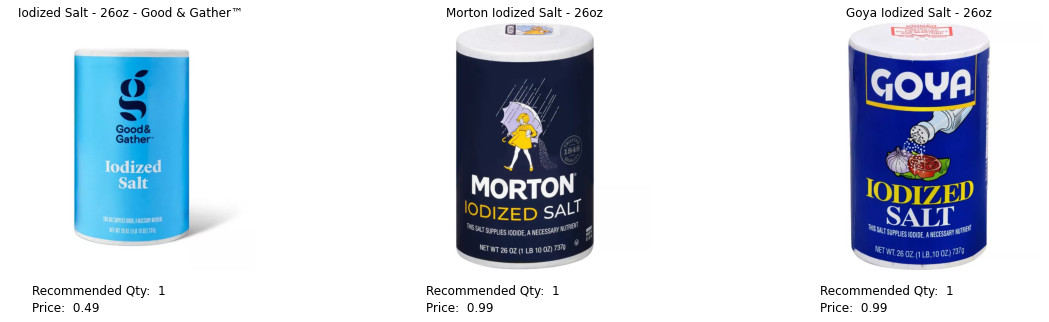

In [19]:
dp.display_products_df(display_df, 3)

### Kitchen Gadgets

In [35]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
    return stored_data
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

# Get list of preprocessed product titles
product_titles = group4['title'].str.lower().values

In [36]:
k=3

# Bi Encoder
multi_lm_embedder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
# Cross encoder 
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-4-v2', max_length=512)
multi_lm_embeddings = get_embeddings(data_path/'hier_embeddings_products4.pkl')

In [44]:
pm = Mapper(group4)
clf_name_class_name = model_path_g4/'nli-classification-class_name'
clf_name_item_type_name = model_path_g4/'nli-classification-item_type_name'
clf_name_subclass_name = model_path_g4/'nli-classification-subclass_name'

embedding_loc = data_path/'hier_embeddings_products4.pkl'
base_clf_class_name = CrossEncoder(clf_name_class_name)
base_clf_item_type_name = CrossEncoder(clf_name_item_type_name)
base_clf_subclass_name = CrossEncoder(clf_name_subclass_name)
clf_class_name = Classifier(base_clf_class_name, pm, 'class_name', threshold=0.99)
clf_item_type_name = Classifier(base_clf_item_type_name, pm, 'item_type_name', threshold=0.99)
clf_subclass_name = Classifier(base_clf_subclass_name, pm, 'subclass_name', threshold=0.99)

In [45]:
filtered_products = list(group4[~pd.isnull(group4['image'])]['tcin'].values)

l1_ranker = TransformerRanker(model=multi_lm_embedder, 
                              max_rank=k,
                              clf=[clf_class_name,
                                   clf_item_type_name,
                                   clf_subclass_name],
                             filtered_products=filtered_products)

l1_ranker.load_embeddings(multi_lm_embeddings)

l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map(embedding_loc),
                                cross_rank=k,
                                bi_rank=30,
                              mapper=pm,
                        weights=True)


dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [46]:
# recipe_loaded = recipe_load_gadget(11000, recipe)
# recipe_loaded = recipe_load_gadget(44366, recipe)
# recipe_loaded = recipe_load_gadget(4768, recipe)
# recipe_loaded = recipe_load_gadget(94560, recipe)
# recipe_loaded = recipe_load_gadget(98701, recipe)
# recipe_loaded = recipe_load_gadget(2342, recipe)
# recipe_loaded = recipe_load_gadget(987, recipe)
# recipe_loaded = recipe_load_gadget(35121, recipe)
# recipe_loaded = recipe_load_gadget(18212, recipe)
# recipe_loaded = recipe_load_gadget(24513, recipe)
recipe_loaded = recipe_load_gadget(769645, recipe)

Apple Oat Breakfast Pancakes


In [47]:
output_dir=Path(model_path_ner/"NER_7")
nlp = spacy.load(output_dir)
doc = nlp(recipe_loaded)
gadgets=[]
methods=[]
method_tools=[]
for ent in doc.ents:
    if ent.label_ == 'GADGET':
        if ent.text.lower() == "oven":
            gadgets.append("electric oven")
        else :
            gadgets.append(ent.text.lower())
    elif ent.label_ == 'METHOD':
        methods.append(ent.text.lower())
gadgets = list(set(gadgets))
methods = list(set(methods))
if 'nonstick skillet' in gadgets and 'skillet' in gadgets:
    gadgets.remove('skillet')
print("Gadgets: " , gadgets)
print("Methods: ", methods)
for key, val in method_tool_mapping.items():
    for word in methods:
        if re.search(val, word, flags=re.I):
            method_tools.append(key)
print("Total: ", list(set(gadgets + method_tools)))   

Gadgets:  ['nonstick skillet', 'cup', 'bowl', 'griddle']
Methods:  ['stir']
Total:  ['nonstick skillet', 'ladle', 'cup', 'bowl', 'griddle']


In [48]:
cooking__tools = preprocess(list(set(gadgets+method_tools)))
ranked_match = l2_ranker.rank_products_recipe(list(cooking__tools), 3)

Filtered nonstick skillet skillet for class_name: BTC CART
Filtered nonstick skillet skillet for item_type_name: Indoor Trash Cans
Filtered ladle for class_name: FASHION OFFICE


In [49]:
rslt_df = group4[['title', 'tcin', 'short_desc','price','net_content_quantity_unit_of_measure', 'net_content_quantity_value']]
final_rslt_df=pd.DataFrame()

for i in range(len(ranked_match)):
    rslt_inter = rslt_df.loc[group4['tcin'].isin(ranked_match[i])] .copy()
    tool = cooking__tools[i]
    length = min(len(ranked_match[i]),9)
    for n in range(0,length):
        for j, row in rslt_inter.iterrows():
            if row.tcin == ranked_match[i][n] :
                rslt_inter.loc[j,'rank']=n+1
                rslt_inter.loc[j,'cooking_tool']=tool
                break
    rslt_inter_n=rslt_inter.sort_values('rank')[0:9] 
    final_rslt_df= pd.concat([final_rslt_df,rslt_inter_n], ignore_index=True)

# rslt_inter
df = final_rslt_df.sort_values(by=['cooking_tool', 'price'])
display_df = df[['tcin', 'cooking_tool', 'price']].copy()


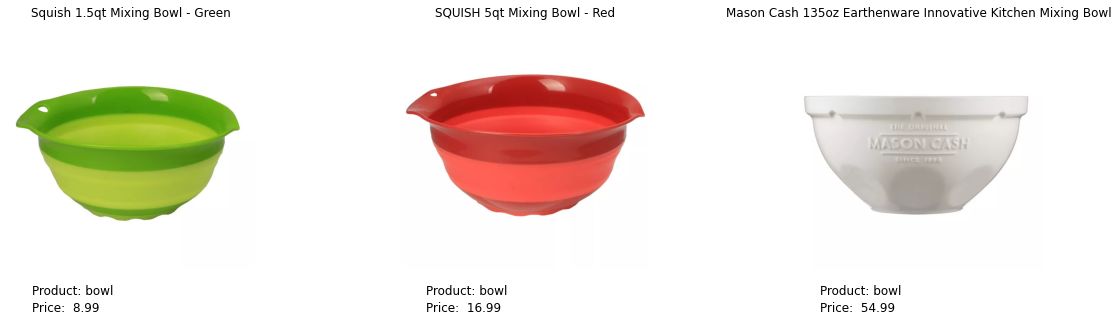

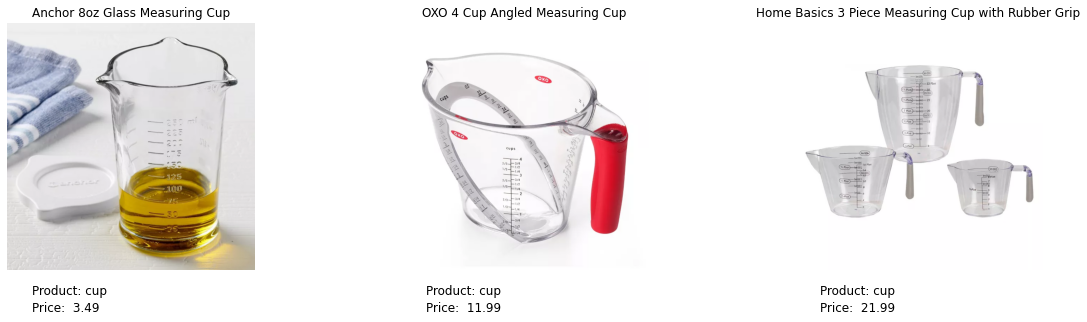

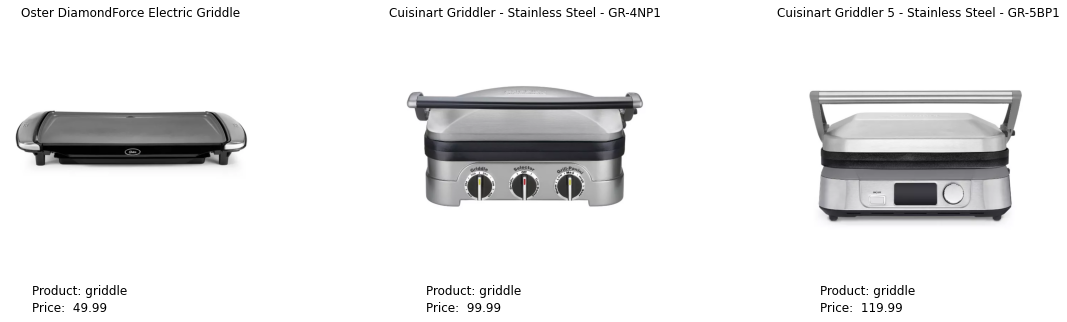

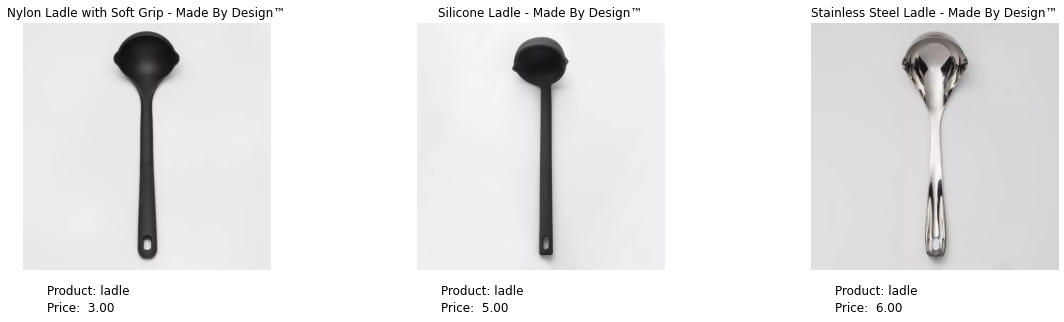

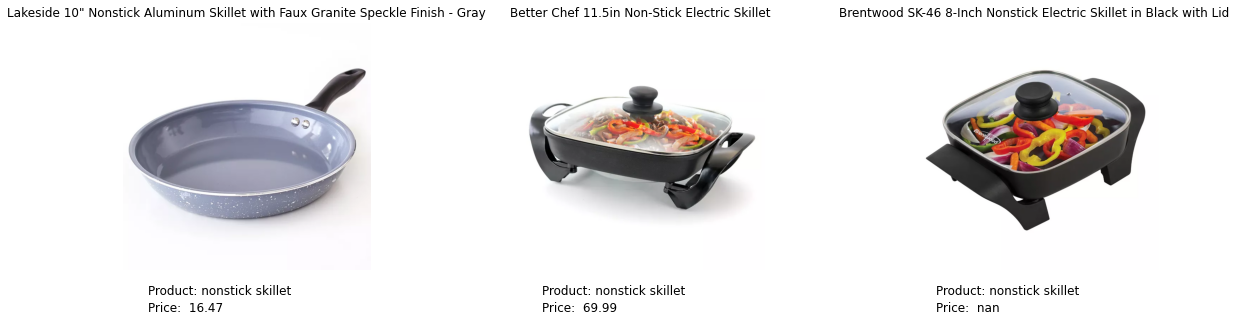

In [50]:
dp.display_products_df_kitchen_gadgets(display_df, 3)

In [279]:
#fine

#4567
#7609
#32659
#4623
#17864
#7124
#87364

# Both
# 82314
# 24513

In [21]:
# problems

# 83468 - only first matches correct
# 83642 - no dairy free
# 7362 - sliced pepporoni
# 21312 - 